              precision    recall  f1-score   support

           0       0.87      0.82      0.85        40
           1       0.82      0.88      0.85        41
           2       1.00      0.97      0.98        33

    accuracy                           0.89       114
   macro avg       0.90      0.89      0.89       114
weighted avg       0.89      0.89      0.89       114

Predicted Posture: Good Posture


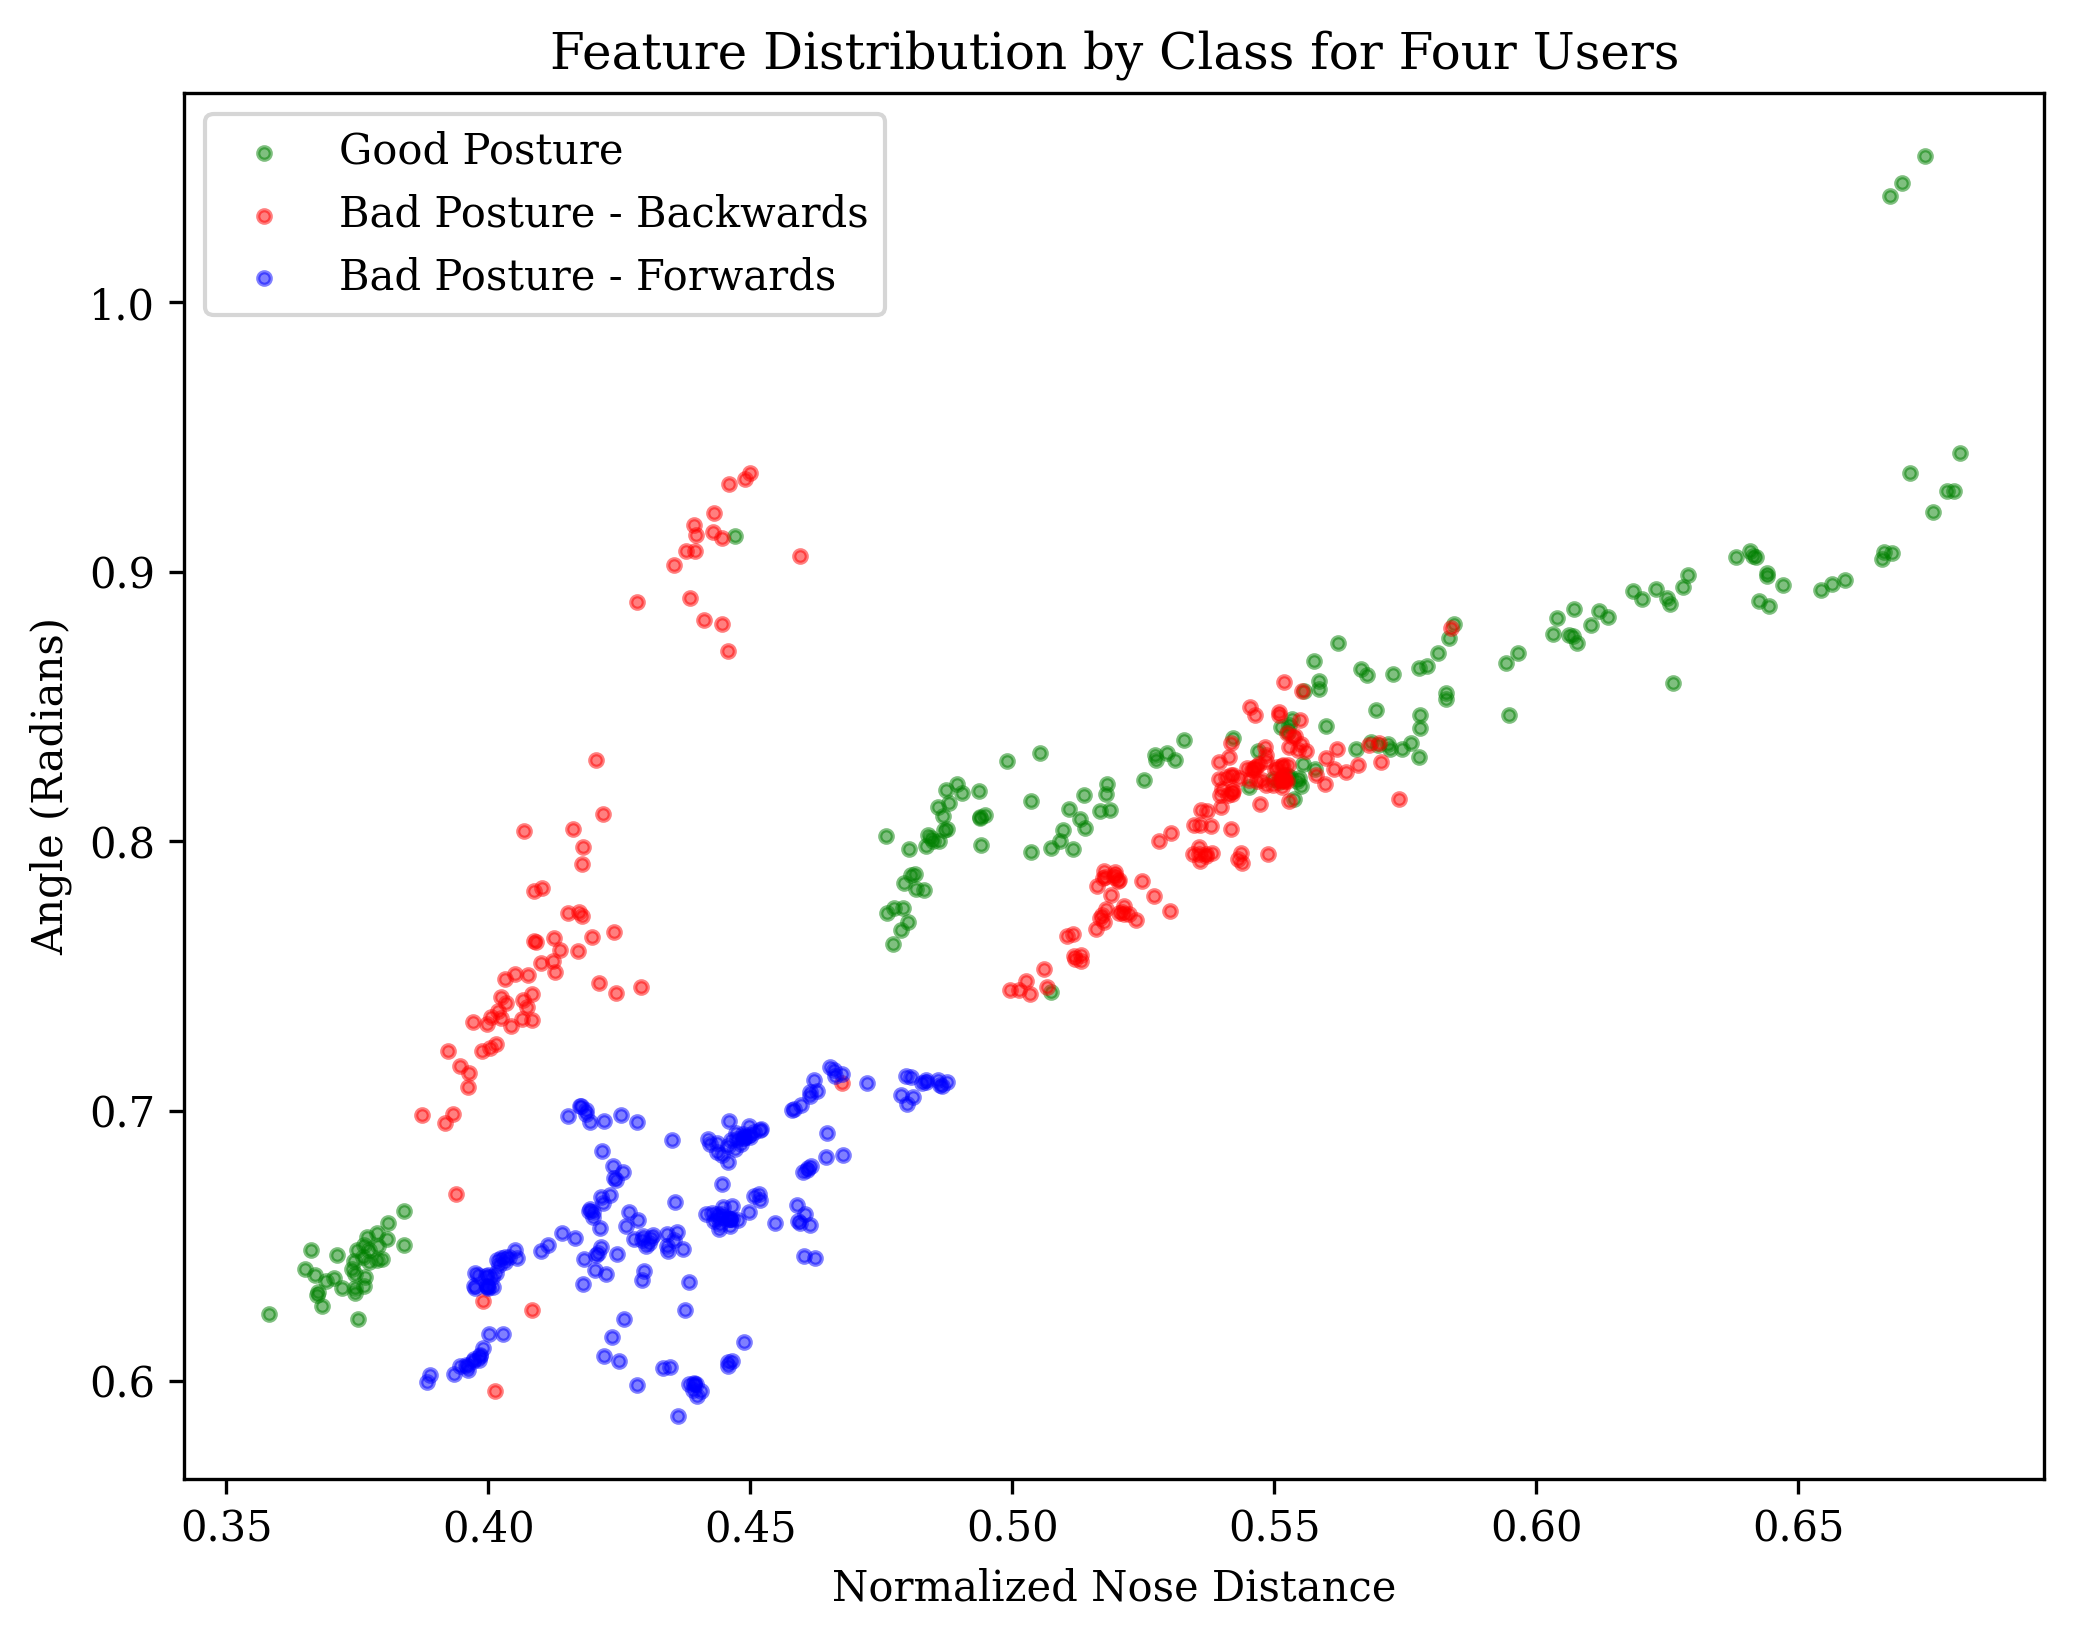

In [15]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.ensemble import GradientBoostingClassifier
import matplotlib

def plotwhite():
    #print on white background for saving
    matplotlib.rcParams.update(matplotlib.rcParamsDefault)
#     plt.style.use('seaborn-paper')
    plt.rcParams['figure.figsize'] = [7, 4]# Figure dimensions
    plt.rcParams['figure.dpi'] = 300
    # plt.rcParams['image.aspect'] = 5                       # Aspect ratio (the CCD is quite long!!!)
    plt.rcParams['lines.linewidth'] = 1
    plt.rcParams['lines.markersize'] = 3
    plt.rcParams['lines.markeredgewidth'] = 0

    cmap = plt.cm.magma
    cmap.set_bad('k',1.)

    plt.rcParams['image.cmap'] = 'magma' # Colormap.
#     plt.rcParams['image.interpolation'] = None
    plt.rcParams['image.origin'] = 'lower'
    plt.rcParams['font.family'] = 'serif'
    plt.rcParams['font.serif'] = 'DejaVu Serif'
    plt.rcParams['mathtext.fontset'] = 'dejavuserif'
    plt.rcParams['axes.prop_cycle'] = \
    plt.cycler(color=["tomato", "dodgerblue", "gold", 'forestgreen', 'mediumorchid', 'lightblue'])
    plt.rcParams['figure.dpi'] = 300

plotwhite()
# Load keypoints data
results_normal = np.load('results_normal.npy')  # Good posture
results_backwards = np.load('results_backwards.npy')  # Bad posture - backwards
results_forwards = np.load('results_forwards.npy')  # Bad posture - forwards
results_normal = results_normal[normal_i]
results_backwards= results_backwards[backwards_i]
results_forwards = results_forwards[forward_i]

def extract_features(keypoints):
    """
    Extract invariant features from keypoints.

    Args:
    - keypoints (numpy array): Array of keypoints for a single image/frame, shape (17, 2).

    Returns:
    - features (numpy array): Extracted features, shape (2,).
    """
    # Keypoint indices
    nose_idx = 0
    left_shoulder_idx = 5
    right_shoulder_idx = 6

    # Extract keypoints
    nose = keypoints[nose_idx]  # Shape (2,)
    left_shoulder = keypoints[left_shoulder_idx]
    right_shoulder = keypoints[right_shoulder_idx]

    # Check for missing keypoints (coordinates [0, 0] or invalid values)
    if np.all(nose == 0) or np.all(left_shoulder == 0) or np.all(right_shoulder == 0):
        return None
    if np.isnan(nose).any() or np.isnan(left_shoulder).any() or np.isnan(right_shoulder).any():
        return None

    # Compute the midpoint between shoulders
    mid_shoulder = (left_shoulder + right_shoulder) / 2

    # Shift origin to mid_shoulder
    nose_rel = nose - mid_shoulder
    left_shoulder_rel = left_shoulder - mid_shoulder
    right_shoulder_rel = right_shoulder - mid_shoulder

    # Compute shoulder width
    shoulder_width = np.linalg.norm(left_shoulder_rel - right_shoulder_rel)
    if shoulder_width == 0:
        return None

    # Compute normalized nose distance from shoulder midpoint
    nose_distance = np.linalg.norm(nose_rel) / shoulder_width

    # Compute angle between shoulder line and vector to nose
    shoulder_line = right_shoulder_rel - left_shoulder_rel
    nose_vector1 = nose - left_shoulder
    nose_vector2 = nose - right_shoulder

    # Compute angle using arccos of the dot product
    dot_product = np.dot(shoulder_line, nose_vector1)
    norms_product = np.linalg.norm(shoulder_line) * np.linalg.norm(nose_vector1)
    if norms_product == 0:
        return None
    cos_theta = dot_product / norms_product
    # Ensure cos_theta is in the valid range [-1, 1]
    cos_theta = np.clip(cos_theta, -1.0, 1.0)
    angle = np.arccos(cos_theta)  # In radians

    # Feature vector
    features = [nose_distance, angle]
    return np.array(features)


# Prepare data
X = []
y = []


def process_keypoints_array(keypoints_array, label):
    """
    Process a keypoints array and append features and labels to X and y.

    Args:
    - keypoints_array (numpy array): Shape (N_samples, 17, 2)
    - label (int): Label for the class
    """
    for keypoints in keypoints_array:
        features = extract_features(keypoints)
        if features is not None:
            X.append(features)
            y.append(label)


# Process each class
process_keypoints_array(results_normal, label=0)  # Good posture
process_keypoints_array(results_backwards, label=1)  # Bad posture - backwards
process_keypoints_array(results_forwards, label=2)  # Bad posture - forwards

X = np.array(X)  # Shape (total_samples, 2)
y = np.array(y)  # Shape (total_samples,)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the classifier
#classifier = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000)
classifier = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,
                                        max_depth=1, random_state=0).fit(X_train, y_train)

# Train the classifier
classifier.fit(X_train, y_train)

# Evaluate the classifier
y_pred = classifier.predict(X_test)
print(classification_report(y_test, y_pred))


def classify_posture(keypoints):
    """
    Classify posture based on keypoints.

    Args:
    - keypoints (numpy array): Keypoints of a single image/frame, shape (17, 2).

    Returns:
    - prediction (int): Predicted class label or None if classification is not possible.
    """
    features = extract_features(keypoints)
    if features is not None:
        prediction = classifier.predict([features])[0]
        return prediction
    else:
        return None


# Assume 'new_keypoints' is a numpy array of keypoints for a new image/frame
new_keypoints = results_normal[0]  # Example using the first sample from results_normal
prediction = classify_posture(new_keypoints)
posture_classes = {0: 'Good Posture', 1: 'Bad Posture - Backwards', 2: 'Bad Posture - Forwards'}
if prediction is not None:
    print(f"Predicted Posture: {posture_classes[prediction]}")
else:
    print("Could not classify posture due to missing keypoints.")

import matplotlib.pyplot as plt

# Plot features
plt.figure(figsize=(8, 6))
colors = ['green', 'red', 'blue']
labels = ['Good Posture', 'Bad Posture - Backwards', 'Bad Posture - Forwards']

for i in range(3):
    idx = y == i
    plt.scatter(X[idx, 0], X[idx, 1], c=colors[i], label=labels[i], alpha=0.5)

plt.xlabel('Normalized Nose Distance')
plt.ylabel('Angle (Radians)')
plt.legend()
plt.title('Feature Distribution by Class for Four Users')
plt.show()


In [1]:
forward_i = [3,
 6,
 13,
 18,
 24,
 25,
 26,
 33,
 38,
 39,
 40,
 64,
 69,
 77,
 78,
 83,
 90,
 91,
 98,
 102,
 103,
 105,
 113,
 114,
 117,
 122,
 124,
 133,
 138,
 140,
 141,
 148,
 154,
 161,
 164,
 168,
 175,
 176,
 177,
 183,
 218,
 219,
 227,
 229,
 230,
 233,
 240,
 248,
 252,
 255,
 256,
 263,
 270,
 271,
 278,
 280,
 283,
 289,
 290,
 291,
 298,
 300,
 305,
 313,
 318,
 319,
 326,
 327,
 340,
 355,
 356,
 363,
 367,
 368,
 370,
 378,
 379,
 382,
 391,
 399,
 409,
 410,
 411,
 420,
 422,
 429,
 430,
 437,
 441,
 457,
 469,
 471,
 478,
 479,
 485,
 486,
 490,
 496,
 503,
 505,
 507,
 512,
 515,
 516,
 524,
 526,
 527,
 533,
 538,
 548,
 549,
 550,
 563,
 564,
 571,
 573,
 578,
 599,
 604,
 609,
 611,
 620,
 623,
 624,
 634,
 639,
 648,
 651,
 658,
 659,
 660,
 666,
 669,
 671,
 678,
 679,
 681,
 686,
 691,
 697,
 698,
 703,
 705,
 712,
 716,
 735,
 744,
 745,
 754,
 756,
 761,
 764,
 775,
 776,
 780,
 787,
 790,
 796,
 799,
 810,
 811,
 819,
 828,
 829,
 834,
 835,
 843,
 848,
 864,
 870,
 875,
 876,
 884,
 885,
 886,
 891,
 895,
 897,
 904,
 905,
 906,
 913,
 922,
 924,
 930,
 933,
 940,
 943,
 944,
 954,
 965,
 974,
 990,
 991,
 992]

normal_i = [4,
 7,
 14,
 20,
 27,
 29,
 30,
 37,
 44,
 45,
 47,
 64,
 75,
 76,
 81,
 91,
 94,
 99,
 109,
 111,
 118,
 123,
 124,
 127,
 136,
 137,
 141,
 146,
 149,
 159,
 164,
 166,
 167,
 174,
 182,
 190,
 193,
 198,
 205,
 206,
 208,
 215,
 259,
 260,
 268,
 271,
 272,
 275,
 284,
 293,
 298,
 301,
 302,
 309,
 316,
 318,
 326,
 329,
 332,
 339,
 340,
 341,
 349,
 352,
 357,
 366,
 373,
 376,
 384,
 386,
 401,
 402,
 403,
 419,
 421,
 430,
 435,
 436,
 439,
 447,
 448,
 452,
 462,
 471,
 483,
 484,
 485,
 495,
 498,
 506,
 508,
 517,
 522,
 531,
 541,
 551,
 554,
 558,
 566,
 567,
 574,
 576,
 581,
 587,
 595,
 597,
 601,
 606,
 610,
 611,
 619,
 622,
 623,
 629,
 634,
 647,
 649,
 650,
 665,
 667,
 675,
 678,
 683,
 707,
 714,
 719,
 722,
 732,
 736,
 737,
 750,
 756,
 766,
 769,
 776,
 777,
 779,
 786,
 789,
 792,
 799,
 801,
 803,
 809,
 815,
 821,
 823,
 830,
 833,
 840,
 846,
 849,
 858,
 867,
 879,
 881,
 891,
 894,
 899,
 903,
 916,
 917,
 923,
 930,
 934,
 941,
 944,
 957,
 959,
 968,
 980,
 982,
 987,
 989,
 999]

backwards_i = [3,
 6,
 13,
 18,
 24,
 25,
 26,
 33,
 38,
 39,
 40,
 64,
 69,
 77,
 78,
 83,
 90,
 91,
 98,
 102,
 103,
 105,
 113,
 114,
 117,
 122,
 123,
 132,
 137,
 139,
 140,
 147,
 153,
 160,
 163,
 167,
 174,
 175,
 176,
 182,
 217,
 218,
 226,
 228,
 229,
 232,
 239,
 247,
 251,
 254,
 255,
 262,
 268,
 269,
 276,
 277,
 280,
 286,
 287,
 288,
 295,
 297,
 302,
 310,
 315,
 316,
 323,
 324,
 337,
 352,
 353,
 360,
 364,
 365,
 367,
 375,
 376,
 379,
 388,
 396,
 406,
 407,
 408,
 417,
 419,
 426,
 427,
 434,
 438,
 454,
 466,
 468,
 475,
 476,
 482,
 483,
 487,
 493,
 500,
 502,
 504,
 509,
 512,
 513,
 521,
 522,
 523,
 529,
 534,
 544,
 545,
 546,
 559,
 560,
 567,
 569,
 574,
 595,
 600,
 605,
 607,
 616,
 619,
 620,
 630,
 635,
 644,
 646,
 653,
 654,
 655,
 661,
 664,
 666,
 673,
 674,
 676,
 681,
 686,
 692,
 693,
 698,
 700,
 707,
 711,
 730,
 739,
 740,
 749,
 751,
 756,
 759,
 770,
 771,
 775,
 782,
 785,
 791,
 794,
 805,
 806,
 814,
 823,
 824,
 829,
 830,
 838,
 843,
 859,
 865,
 870,
 871,
 879,
 880,
 881,
 886,
 889,
 891,
 898,
 899,
 900,
 906,
 915,
 917,
 923,
 926,
 933,
 936,
 937,
 947,
 958,
 967,
 983,
 984,
 985,
 996,
 999]